In [16]:
import os
import warnings

import numpy as np
import pymc3 as pm
import pandas as pd
import pandas_profiling
from scipy import stats
from sklearn.linear_model import LinearRegression
import sklearn.preprocessing as preprocessing

import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

warnings.simplefilter(action="ignore", category=FutureWarning)

#%config InlineBackend.figure_format = 'retina'
#az.style.use("arviz-darkgrid")
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC3 v3.11.2
Running on ArviZ v0.11.2


In [2]:
data_dir = '/home/telescreen/Workspace/fun/pymc-devs-resources/Rethinking_2/Data/'

In [3]:
np.random.seed(3)

N = 200
nw = np.random.normal(size=N)
tw = np.random.normal(size=N)
s = nw + tw
q = np.quantile(s, 0.9)
selected = s >= q
cor = np.corrcoef(nw[selected], tw[selected])
cor

array([[ 1.        , -0.74495204],
       [-0.74495204,  1.        ]])

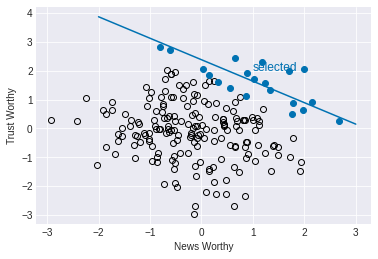

In [4]:
plt.scatter(nw[~selected], tw[~selected], edgecolors='k', lw=1, color=(0, 0, 0, 0))
plt.scatter(nw[selected], tw[selected], color='C0')
plt.text(1, 2, "selected", color='C0', fontsize='large')
xn = np.array([-2, 3])
plt.plot(xn, tw[selected].mean() + cor[0, 1]*(xn - nw[selected].mean()))
plt.xlabel('News Worthy')
plt.ylabel('Trust Worthy');

In [5]:
# Multicolinearity
N = 100
height = np.random.normal(10, 2, size=N)
leg_prob = np.random.uniform(0.4, 0.5)
leg_left = leg_prob*height + np.random.normal(0, 0.02, size=N)
leg_right = leg_prob*height + np.random.normal(0, 0.02, size=N)
legdata = pd.DataFrame(
    np.vstack([height, leg_left, leg_right]).T,
    columns=['height', 'leg_left', 'leg_right']
)
legdata.head()

,height,leg_left,leg_right
0,10.178107,4.193684,4.176532
1,11.557794,4.745369,4.774994
2,12.529290,5.152883,5.174820
3,8.238977,3.405412,3.434842
4,10.472811,4.330703,4.298668


In [6]:
with pm.Model() as m6_1:
    sigma = pm.Exponential('sigma', 1)
    bl = pm.Normal('leg_left', 2, 10)
    br = pm.Normal('leg_right', 2, 10)
    intercept = pm.Normal('intercept', 10, 100)
    mu = intercept + bl*legdata.leg_left + br*legdata.leg_right
    height = pm.Normal('height', mu, sigma, observed=legdata.height)
    trace6_1 = pm.sample()
az.summary(trace6_1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, leg_right, leg_left, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 147 seconds.
There were 306 divergences after tuning. Increase `target_accept` or reparameterize.
There were 328 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 239 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
leg_left,1.315,0.144,1.066,1.570,0.010,0.007,233.0,728.0,1.02
leg_right,1.105,0.144,0.838,1.345,0.010,0.007,238.0,688.0,1.02
intercept,0.013,0.020,-0.024,0.049,0.001,0.001,699.0,660.0,1.01
sigma,0.037,0.002,0.033,0.042,0.000,0.000,40.0,54.0,1.08


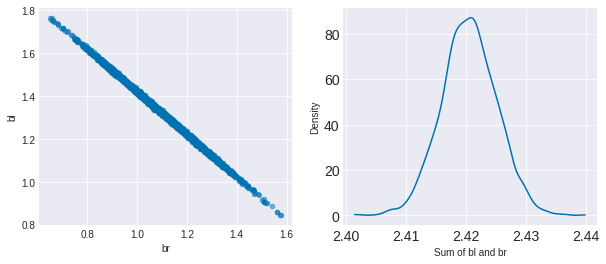

In [14]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[10, 4])

ax1.scatter(trace6_1[br], trace6_1[bl], alpha=0.5, s=20)
ax1.set_xlabel('br')
ax1.set_ylabel('bl')

az.plot_kde(trace6_1[br] + trace6_1[bl], ax=ax2)
ax2.set_ylabel('Density')
ax2.set_xlabel('Sum of bl and br');

In [7]:
import statsmodels.formula.api as smf

mod = smf.ols(formula='height ~ leg_left + leg_right', data=legdata)
result = mod.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.427e+05
Date:                Fri, 15 Oct 2021   Prob (F-statistic):          5.79e-169
Time:                        19:46:04   Log-Likelihood:                 192.65
No. Observations:                 100   AIC:                            -379.3
Df Residuals:                      97   BIC:                            -371.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0139      0.019      0.714      0.4

In [22]:
def normalize(series):
    return (series - series.mean()) / series.std()

In [19]:
milk = pd.read_csv(os.path.join(data_dir, 'milk.csv'), delimiter=';')
milk.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [24]:
milk.loc[:, 'K'] = normalize(milk['kcal.per.g'])
milk.loc[:, 'F'] = normalize(milk['perc.fat'])
milk.loc[:, 'L'] = normalize(milk['perc.lactose'])

milk.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,F,L
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-1.217243,1.307262
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.816126,-1.030355,1.011285
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.125913,-1.391531,1.382679
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.001998,-1.335535,1.586874
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.258511,-0.469693,0.257115


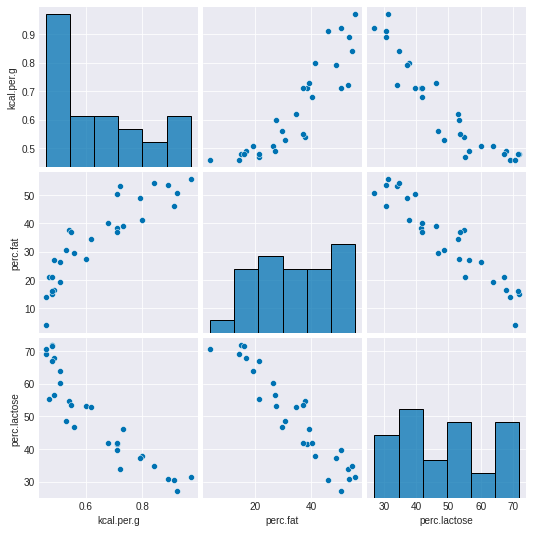

In [26]:
sns.pairplot(milk, vars=['kcal.per.g', 'perc.fat', 'perc.lactose'])

In [36]:
milk[['kcal.per.g', 'perc.fat', 'perc.lactose']].corr()

,kcal.per.g,perc.fat,perc.lactose
kcal.per.g,1.000000,0.886943,-0.921118
perc.fat,0.886943,1.000000,-0.941637
perc.lactose,-0.921118,-0.941637,1.000000


In [30]:
with pm.Model() as m6_3:
    intercept = pm.Normal('intercept', 0, 0.2)
    bF = pm.Normal('bF', 0, 0.5)
    mu = intercept + bF*milk.F
    sigma = pm.Exponential('sigma', 1)
    K = pm.Normal('K', mu, sigma, observed=milk.K)
    trace6_3 = pm.sample()
az.summary(trace6_3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bF, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.001,0.086,-0.160,0.159,0.001,0.001,5343.0,2684.0,1.0
bF,0.858,0.092,0.693,1.037,0.001,0.001,4615.0,3035.0,1.0
sigma,0.487,0.071,0.366,0.616,0.001,0.001,3940.0,2713.0,1.0


In [31]:
with pm.Model() as m6_4:
    intercept = pm.Normal('intercept', 0, 0.2)
    bL = pm.Normal('bL', 0, 0.5)
    mu = intercept + bL*milk.L
    sigma = pm.Exponential('sigma', 1)
    K = pm.Normal('K', mu, sigma, observed=milk.K)
    trace6_4 = pm.sample()
az.summary(trace6_4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bL, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.001,0.071,-0.136,0.126,0.001,0.001,4466.0,3391.0,1.0
bL,-0.900,0.078,-1.049,-0.757,0.001,0.001,4289.0,2613.0,1.0
sigma,0.412,0.059,0.311,0.522,0.001,0.001,4106.0,2730.0,1.0


In [33]:
with pm.Model() as m6_5:
    intercept = pm.Normal('intercept', 0, 0.2)
    bL = pm.Normal('bL', 0, 0.5)
    bF = pm.Normal('bF', 0, 0.5)
    mu = intercept + bL*milk.L + bF*milk.F
    sigma = pm.Exponential('sigma', 1)
    K = pm.Normal('K', mu, sigma, observed=milk.K)
    trace6_5 = pm.sample()
az.summary(trace6_5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bF, bL, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.001,0.074,-0.137,0.138,0.002,0.001,2405.0,2058.0,1.0
bL,-0.664,0.198,-1.043,-0.301,0.005,0.004,1547.0,2047.0,1.0
bF,0.256,0.198,-0.140,0.615,0.005,0.004,1595.0,2206.0,1.0
sigma,0.416,0.063,0.308,0.532,0.001,0.001,1993.0,1431.0,1.0


In [44]:
N = 100
h0 = np.random.normal(10, 2, N)
treatment = np.repeat([0, 1], N/2)
fungus = np.random.binomial(1, 0.5 - 0.3*treatment, N)
h1 = h0 + np.random.normal(5 - 3*fungus, 1, N)
fgdat = pd.DataFrame(np.vstack([h0, h1, treatment, fungus]).T, 
                        columns=['h0', 'h1', 'treatment', 'fungus'])
az.summary(fgdat.to_dict(orient='list'), kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
h0,10.26,2.14,6.43,14.45
h1,14.00,2.78,8.54,18.48
treatment,0.50,0.50,0.00,1.00
fungus,0.34,0.48,0.00,1.00


In [51]:
fgdat.head()

,h0,h1,treatment,fungus
0,12.446393,16.848974,0.0,0.0
1,14.322884,16.640098,0.0,1.0
2,11.653091,16.425283,0.0,0.0
3,8.718461,14.220774,0.0,0.0
4,9.363723,10.636099,0.0,1.0


array([[<AxesSubplot:title={'center':'h0'}>,
        <AxesSubplot:title={'center':'h1'}>],
       [<AxesSubplot:title={'center':'treatment'}>,
        <AxesSubplot:title={'center':'fungus'}>]], dtype=object)

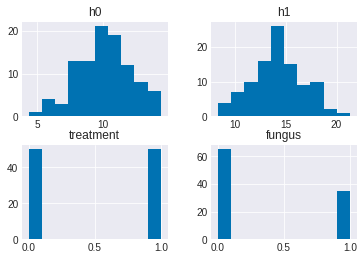

In [39]:
fgdat.hist()

In [46]:
sim_p = np.random.lognormal(0, 0.25, int(1e4))
az.summary(sim_p, kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
x,1.03,0.26,0.56,1.52


In [48]:
with pm.Model() as m6_6:
    p = pm.Lognormal('p', 0, 0.25)
    mu = p * fgdat.h0
    sigma = pm.Exponential('sigma', 1)
    h1 = pm.Normal('h1', mu, sigma, observed=fgdat.h1)
    trace6_6 = pm.sample()
az.summary(trace6_6, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,1.35,0.02,1.31,1.38,0.0,0.0,3211.42,2650.62,1.0
sigma,1.95,0.14,1.69,2.22,0.0,0.0,3102.74,2441.90,1.0


In [52]:
with pm.Model() as m6_7:
    intercept = pm.Normal('intercept', 0, 0.2)
    bt = pm.Normal('bt', 0, 0.5)
    bf = pm.Normal('bf', 0, 0.5)
    p = intercept + bt*fgdat.treatment + bf*fgdat.fungus
    mu = p * fgdat.h0
    sigma = pm.Exponential('sigma', 1)
    h1 = pm.Normal('h1', mu, sigma, observed=fgdat.h1)
    trace6_7 = pm.sample()
az.summary(trace6_7, kind='stats', round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bf, bt, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8829276638542007, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_3%,hdi_97%
intercept,1.43,0.02,1.39,1.48
bt,0.01,0.03,-0.04,0.06
bf,-0.27,0.03,-0.33,-0.22
sigma,1.35,0.10,1.17,1.53


In [53]:
with pm.Model() as m6_8:
    intercept = pm.Normal('intercept', 0, 0.2)
    bt = pm.Normal('bt', 0, 0.5)
    p = intercept + bt*fgdat.treatment
    mu = p * fgdat.h0
    sigma = pm.Exponential('sigma', 1)
    h1 = pm.Normal('h1', mu, sigma, observed=fgdat.h1)
    trace6_8 = pm.sample()
az.summary(trace6_8, kind='stats', round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bt, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%
intercept,1.28,0.03,1.23,1.33
bt,0.12,0.04,0.05,0.18
sigma,1.90,0.14,1.67,2.17


In [54]:
# Fungus imaginary data. Moisture affect both fungus and plant growth
N = 100
h0 = np.random.normal(10, 2, N)
treatment = np.repeat([0, 1], N/2)
M = np.random.binomial(1, 0.5, N)
fungus = np.random.binomial(1, 0.5 - 0.4*treatment + 0.4*M, N)
h1 = h0 + np.random.normal(5 + 3*M, 1, N)
fgdat2 = pd.DataFrame(np.vstack([h0, h1, treatment, fungus, M]).T, 
                        columns=['h0', 'h1', 'treatment', 'fungus', 'moisture'])
az.summary(fgdat2.to_dict(orient='list'), kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
h0,10.09,2.17,5.53,13.34
h1,16.74,3.01,10.90,21.59
treatment,0.50,0.50,0.00,1.00
fungus,0.57,0.50,0.00,1.00
moisture,0.51,0.50,0.00,1.00


In [57]:
with pm.Model() as m6_72:
    intercept = pm.Normal('intercept', 0, 0.2)
    bt = pm.Normal('bt', 0, 0.5)
    bf = pm.Normal('bf', 0, 0.5)
    p = intercept + bt*fgdat2.treatment + bf*fgdat2.fungus
    mu = p * fgdat.h0
    sigma = pm.Exponential('sigma', 1)
    h1 = pm.Normal('h1', mu, sigma, observed=fgdat2.h1)
    trace6_72 = pm.sample()
az.summary(trace6_72, kind='stats', round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bf, bt, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%
intercept,1.15,0.09,0.98,1.32
bt,0.26,0.10,0.08,0.45
bf,0.38,0.10,0.20,0.56
sigma,4.84,0.37,4.20,5.56


In [58]:
with pm.Model() as m6_82:
    intercept = pm.Normal('intercept', 0, 0.2)
    bt = pm.Normal('bt', 0, 0.5)
    p = intercept + bt*fgdat2.treatment
    mu = p * fgdat2.h0
    sigma = pm.Exponential('sigma', 1)
    h1 = pm.Normal('h1', mu, sigma, observed=fgdat2.h1)
    trace6_82 = pm.sample()
az.summary(trace6_82, kind='stats', round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bt, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%
intercept,1.58,0.03,1.53,1.64
bt,0.07,0.05,-0.02,0.15
sigma,2.29,0.17,1.99,2.60


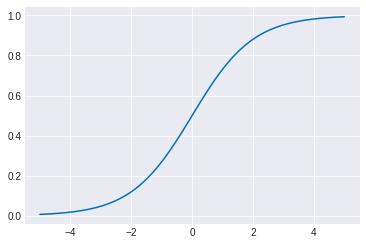

In [80]:
from scipy.special import expit, logit
x = np.linspace(-5, 5, 50)
plt.plot(x, expit(x))

In [81]:
def sim_happiness(NYear=100, seed=1234):
    from scipy.special import expit
    np.random.seed(1234)
    data = pd.DataFrame(np.zeros((65*20, 3)), columns=['age', 'happiness', 'married'])
    data.loc[:, 'age'] = np.repeat(np.arange(65), 20)
    data.loc[:, 'happiness'] = np.repeat(np.linspace(-2, 2, 20), 65)
    data.loc[:, 'married'] = data.loc[:, 'married'].astype(bool)
    
    for i in range(NYear):
        data.loc[:, 'age'] += 1
        # retired old fork
        old = data.age == 65
        data.loc[old, 'age'] = 0
        data.loc[old, 'happiness'] = np.linspace(-2, 2, 20)
        data.loc[old, 'married'] = False
        # Married
        eligible = (data.married == 0) & (data.age >= 18)
        marry = np.random.binomial(1, expit(data.loc[eligible, 'happiness'] - 4)) == 1
        data.loc[eligible, 'married'] = marry
    data.sort_values('age', inplace=True, ignore_index=True)
    return data

In [135]:
popn = sim_happiness()
az.summary(popn.to_dict(orient='list'), kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
age,32.00,18.77,0.0,61.00
happiness,-0.00,1.21,-2.0,1.79
married,0.28,0.45,0.0,1.00


Text(0, 0.5, 'happiness')

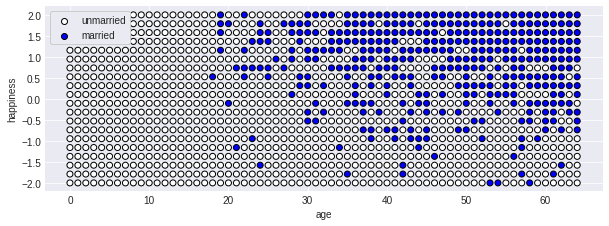

In [129]:
fig, ax = plt.subplots(figsize=[10, 3.4])
colors = np.array(['w']*popn.shape[0])
colors[popn.married] = 'b'
ax.scatter(popn.age, popn.happiness, edgecolors='k', color=colors)
ax.scatter([], [], edgecolors='k', color='w', label='unmarried')
ax.scatter([], [], edgecolors='k', color='b', label='married')
ax.legend(loc='upper left', frameon=True, framealpha=1)
ax.set_xlabel('age')
ax.set_ylabel('happiness')

In [152]:
popn2 = popn[popn.age > 17].copy()
popn2['A'] = (popn2.loc[:, 'age'] - 18) / (65-18)
popn2.reset_index()

,index,age,happiness,married,A
0,360,18,0.526316,True,0.000000
1,361,18,0.736842,False,0.000000
2,362,18,0.947368,False,0.000000
3,363,18,1.157895,False,0.000000
4,364,18,2.000000,False,0.000000
...,...,...,...,...,...
935,1295,64,-1.578947,False,0.978723
936,1296,64,-1.789474,False,0.978723
937,1297,64,-2.000000,False,0.978723
938,1298,64,-0.105263,False,0.978723


In [153]:
mid = popn2.married.astype(int)
with pm.Model() as m6_9:
    intercept = pm.Normal('intercep', 0, 1, shape=2)
    bA = pm.Normal('bA', 0, 2)
    mu = intercept[mid] + bA * popn2.A
    sigma = pm.Exponential('sigma', 1)
    happiness = pm.Normal('happiness', mu, sigma, observed=popn2.happiness)
    trace6_9 = pm.sample()
az.summary(trace6_9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, intercep]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercep[0],-0.200,0.070,-0.334,-0.074,0.002,0.001,1849.0,2198.0,1.0
intercep[1],1.212,0.094,1.035,1.386,0.002,0.002,1742.0,2011.0,1.0
bA,-0.715,0.127,-0.952,-0.480,0.003,0.002,1616.0,1948.0,1.0
sigma,1.021,0.023,0.976,1.065,0.000,0.000,2627.0,2431.0,1.0


In [154]:
with pm.Model() as m6_10:
    intercept = pm.Normal('intercep', 0, 1)
    bA = pm.Normal('bA', 0, 2)
    mu = bA * popn2.A
    sigma = pm.Exponential('sigma', 1)
    happiness = pm.Normal('happiness', mu, sigma, observed=popn2.happiness)
    trace6_10 = pm.sample()
az.summary(trace6_10)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, intercep]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercep,-0.027,0.998,-1.946,1.776,0.014,0.016,5189.0,3060.0,1.0
bA,0.000,0.068,-0.128,0.127,0.001,0.001,5667.0,3171.0,1.0
sigma,1.215,0.029,1.163,1.268,0.000,0.000,6370.0,3071.0,1.0


In [169]:
## Collider Bias - Unobserved
# Unknown environment factor and parent's education affect Child's education
# No direct impact from GrandParent education to Child's education
N = 200
b_GP = 1
b_PC = 1
b_GC = 0
b_U = 2
U = 2*np.random.binomial(1, 0.5, N) - 1
G = np.random.normal(0, 1, N)
P = np.random.normal(b_GP*G + b_U*U)
C = np.random.normal(b_GC*G + b_PC*P + b_U*U)
edu = pd.DataFrame(np.vstack([U, G, P, C]).T, columns=['U', 'G', 'P', 'C'])

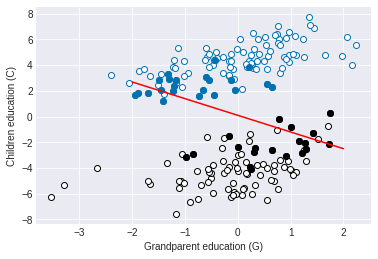

In [180]:
bad = U < 0
good = ~bad
plt.scatter(G[good], C[good], color='w', edgecolor='C0')
plt.scatter(G[bad], C[bad], color='w', edgecolors='k')
eP = (P > -1) & (P < 1)
plt.scatter(G[good & eP], C[good & eP], color='C0', edgecolors='C0')
plt.scatter(G[bad & eP], C[bad & eP], color='k', edgecolors='k')

p = np.polyfit(G[eP], C[eP], 1)
xn = np.array([-2, 2])
plt.plot(xn, np.polyval(p, xn), color='r')

plt.xlabel('Grandparent education (G)')
plt.ylabel('Children education (C)');

In [165]:
with pm.Model() as m6_11:
    intercept = pm.Normal('intercept', 0, 1)
    b_GC = pm.Normal('GC', 0, 1)
    b_PC = pm.Normal('PC', 0, 1)
    sigma = pm.Exponential('sigma', 1)
    mu = intercept + b_GC*edu.G + b_PC*edu.P
    C = pm.Normal('C', mu, sigma, observed=edu.C)
    trace6_11 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, PC, GC, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [166]:
az.summary(trace6_11, kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
intercept,-0.06,0.09,-0.23,0.11
GC,-0.83,0.10,-1.01,-0.65
PC,1.82,0.04,1.75,1.90
sigma,1.28,0.06,1.16,1.40
